In [12]:
%config InlineBackend.figure_format = 'retina'
import re
import json
import random
import time
import pickle
from brokenaxes import brokenaxes
from striprtf.striprtf import rtf_to_text
from glob import glob
from multiprocessing import Pool
from scipy.io import mmread
from collections import OrderedDict
import pandas as pd
from scipy.stats.mstats import gmean
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr, zscore, ttest_ind, ranksums, spearmanr, fisher_exact
import os, sys
import statsmodels.api as sm
from copy import deepcopy
import numpy as np
from scipy.sparse import csr_matrix
from collections import Counter, defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import itertools
from statannotations.Annotator import Annotator
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams["font.sans-serif"] = "Arial"
import tqdm 

In [13]:
def p2signif(p):
    if p<.05:
        if p<.01:
            if p<.001: return "***"
            else: return "**"
        else: return "*"
    else: return ""

### Figure 1C Normalized cell-free eccDNA counts detected in healthy individuals and patients across multiple cancer types.

In [3]:
### 经过长度片段筛选后的cell-free eccDNA epm值比较
# 指定目录路径
directory = "/home/luosongwen/scantecc/2025_new_data/Scantecc_eccDNA_bed"

# 获取目录下所有bed文件路径
bed_files = glob(os.path.join(directory, "*.bed"))

# 创建一个空列表用于存储每个文件生成的DataFrame
dataframes = []

# 循环读取所有bed文件
for file in bed_files:
    # 提取文件名（不含路径和扩展名）
    file_id = os.path.splitext(os.path.basename(file))[0]
    
    # 读取bed文件为DataFrame并设置列名
    df = pd.read_csv(file, sep='\t', header=None, names=["chr", "start", "end", "ecc_id"], engine='python')
    
    # 添加'id'列作为文件名
    df['id'] = file_id
    df["length"] = df["end"]-df["start"]
    # 将DataFrame添加到列表中
    dataframes.append(df)

# 将所有DataFrame合并为一个总DataFrame
combined_df = pd.concat(dataframes, ignore_index=True)

In [4]:
###读入测序reads信息文件
reads_info = pd.read_csv("/home/luosongwen/scantecc/2025_new_data/reads_info.txt", sep='\t')
reads_info.rename(columns={"送测编号": "id"}, inplace=True)

In [5]:
###读入meta信息文件
metadata = pd.read_table("/home/luosongwen/scantecc/2025_new_data/meta_information.txt", index_col=0)
id2label = metadata['label'].to_dict()
ctype_mapping = {
    '正常对照': 'Health',
    '肺癌': 'Lung',
    '卵巢癌':'Ovarian',
    '胃癌':'Gastric',
    '淋巴瘤':'Lymphoma',
    '结直肠癌':'Colorectal',
    '乳腺癌': 'Breast',
    'other':'Others'
}
metadata['ctype'] = metadata['ctype'].replace(ctype_mapping)

# 删除所有以 'Unnamed:' 开头的列
metadata = metadata.loc[:, ~metadata.columns.str.startswith('Unnamed:')]

# 修改列名
metadata = metadata.rename(columns={
    "病理分期": "Pathological_Stage",
    "简化分期": "Simplified_Stage",
    "Gender(女=1_x000D_\n男=2)": "Gender"
})

# 替换 Gender 列中的值
metadata["Gender"] = metadata["Gender"].replace({"1": "female", "2": "male"})
metadata["id"] = metadata.index

In [6]:
combined_df = combined_df.merge(metadata[['id', 'label', 'ctype']], on='id', how='left')
combined_df.drop(combined_df.loc[combined_df['chr']=='chrM'].index, inplace = True)
combined_df.reset_index(inplace=True)
filtered_df = combined_df[combined_df["length"] <= 10**6]
filtered_df['label'] = filtered_df['label'].replace({'Disease': 'Cancer', 'Normal': 'Health'})
filtered_df.drop(columns=["index"], inplace=True)

/tmp/ipykernel_1223/3221210058.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['label'] = filtered_df['label'].replace({'Disease': 'Cancer', 'Normal': 'Health'})
/tmp/ipykernel_1223/3221210058.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.drop(columns=["index"], inplace=True)


In [7]:
###统计每个样本的eccDNA的数目
eccDNA_count_df = filtered_df.groupby("id").size().reset_index(name="eccDNA_total_count")
eccDNA_count_df = eccDNA_count_df.merge(filtered_df[['id', 'label', 'ctype']], on='id', how='left')
eccDNA_count_df = eccDNA_count_df.merge(reads_info[['id', 'MappedReads']], on='id', how='left')
eccDNA_count_df = eccDNA_count_df.drop_duplicates()
eccDNA_count_df["epm"] = eccDNA_count_df["eccDNA_total_count"] / eccDNA_count_df["MappedReads"] * pow(10, 6)
#eccDNA_count_df['log_epm'] = eccDNA_count_df['epm'].map(lambda x:np.log2(x))
eccDNA_count_df['label'] = eccDNA_count_df['label'].replace({'Disease': 'Cancer', 'Normal': 'Health'})

In [9]:
orders = ['Health','Lung','Ovarian','Gastric','Lymphoma', 'Colorectal','Breast','Others']
eccDNA_count_df["ctype"] = pd.Categorical(eccDNA_count_df["ctype"], categories=orders, ordered=True)
eccDNA_count_df = eccDNA_count_df.sort_values("ctype")

/tmp/ipykernel_1223/2087021386.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_1223/2087021386.py:5: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.barplot(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Health vs. Lung: t-test independent samples, P_val:7.433e-09 t=-5.899e+00
Health vs. Ovarian: t-test independent samples, P_val:1.060e-06 t=-4.981e+00
Health vs. Gastric: t-test independent samples, P_val:7.764e-10 t=-6.367e+00
Health vs. Lymphoma: t-test independent samples, P_val:1.874e-04 t=-3.786e+00
Health vs. Colorectal: t-test independent samples, P_val:1.340e-03 t=-3.243e+00
Health vs. Breast: t-test independent samples, P_val:1.161e-09 t=-6.328e+00
Health vs. Others: t-test independent samples, P_val:5.341e-08 t=-5.595e+00


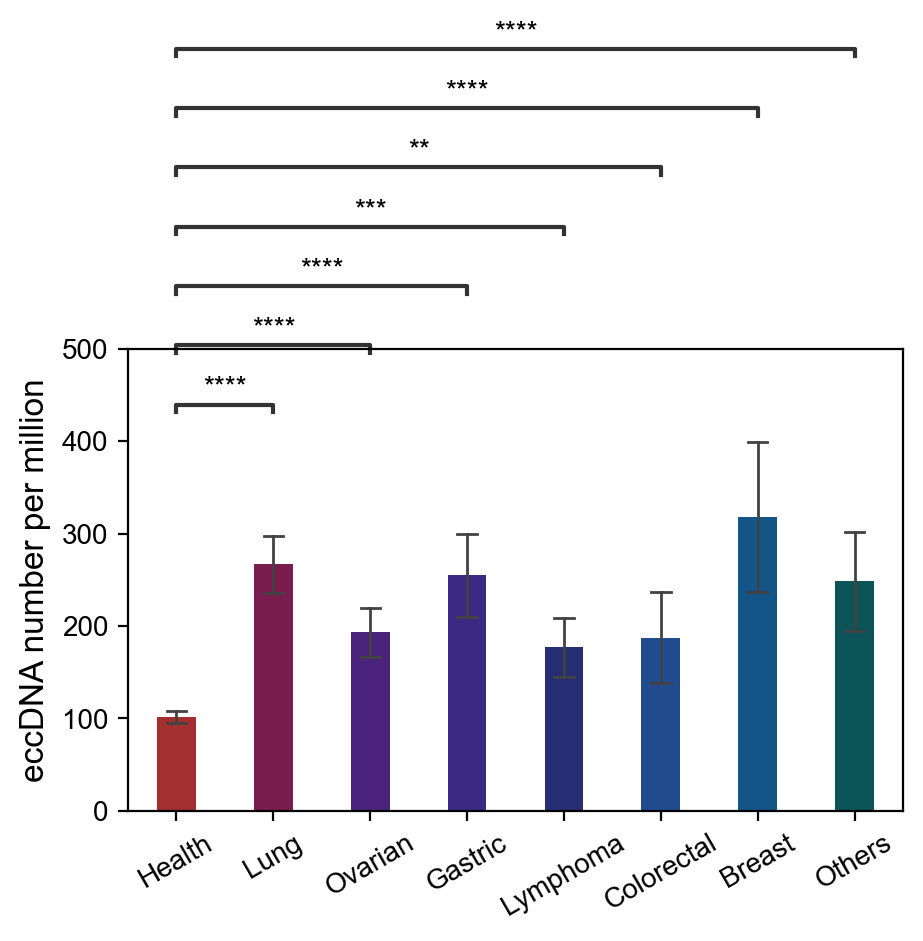

In [14]:
# 创建画布和坐标轴
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

# 使用 barplot 替代 boxplot，添加误差线为标准误差（sem）
sns.barplot(
    data=eccDNA_count_df,
    x='ctype', y='epm',
    errorbar='se',  # 设置误差线为标准误差
    ax=ax,
    capsize=0.2,
    errwidth=1, width=0.4,
    palette=['#b71c1c', '#880e4f', '#4a148c', '#311b92', '#1a237e', '#0d47a1', '#01579b', '#006064']
)

# 叠加散点图
#sns.stripplot(
    #data=filtered_eccDNA_count_df,
    #x='ctype', y='epm', ax=ax,
    #marker='o', color='k', size=4, alpha=0.8,
    #palette=['#661212', '#4c092f', '#260c4c', '#160f4c', '#0d133f', '#07234c', '#012e4c', '#003333']
#)

# 添加显著性标记
box_pairs = [
    ("Health", "Lung"),
    ("Health", "Ovarian"),
    ("Health", "Gastric"),
    ("Health", "Lymphoma"),
    ("Health", "Colorectal"),
    ("Health", "Breast"),
    ("Health", "Others"),
]

annot = Annotator(ax, box_pairs, data=eccDNA_count_df, x="ctype", y="epm")
annot.configure(test='t-test_ind', text_format='star', loc='outside')
annot.apply_and_annotate()

# 设置标签
plt.xlabel("")
plt.ylabel("eccDNA number per million", fontsize=12)
plt.xticks(rotation=30)
plt.ylim(0,500)
#plt.savefig('/home/luosongwen/scantecc/2025_03_10_Figure_result/candidate_figure/2025_04_16_Figure1b_barplot_without_stripplot.pdf', bbox_inches='tight')

# 显示图形
plt.show()

/tmp/ipykernel_28422/3282364576.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Health vs. Lung: t-test independent samples, P_val:7.433e-09 t=-5.899e+00
Health vs. Ovarian: t-test independent samples, P_val:1.060e-06 t=-4.981e+00
Health vs. Gastric: t-test independent samples, P_val:7.764e-10 t=-6.367e+00
Health vs. Lymphoma: t-test independent samples, P_val:1.874e-04 t=-3.786e+00
Health vs. Colorectal: t-test independent samples, P_val:1.340e-03 t=-3.243e+00
Health vs. Breast: t-test independent samples, P_val:1.161e-09 t=-6.328e+00
Health vs. Others: t-test independent samples, P_val:5.341e-08 t=-5.595e+00


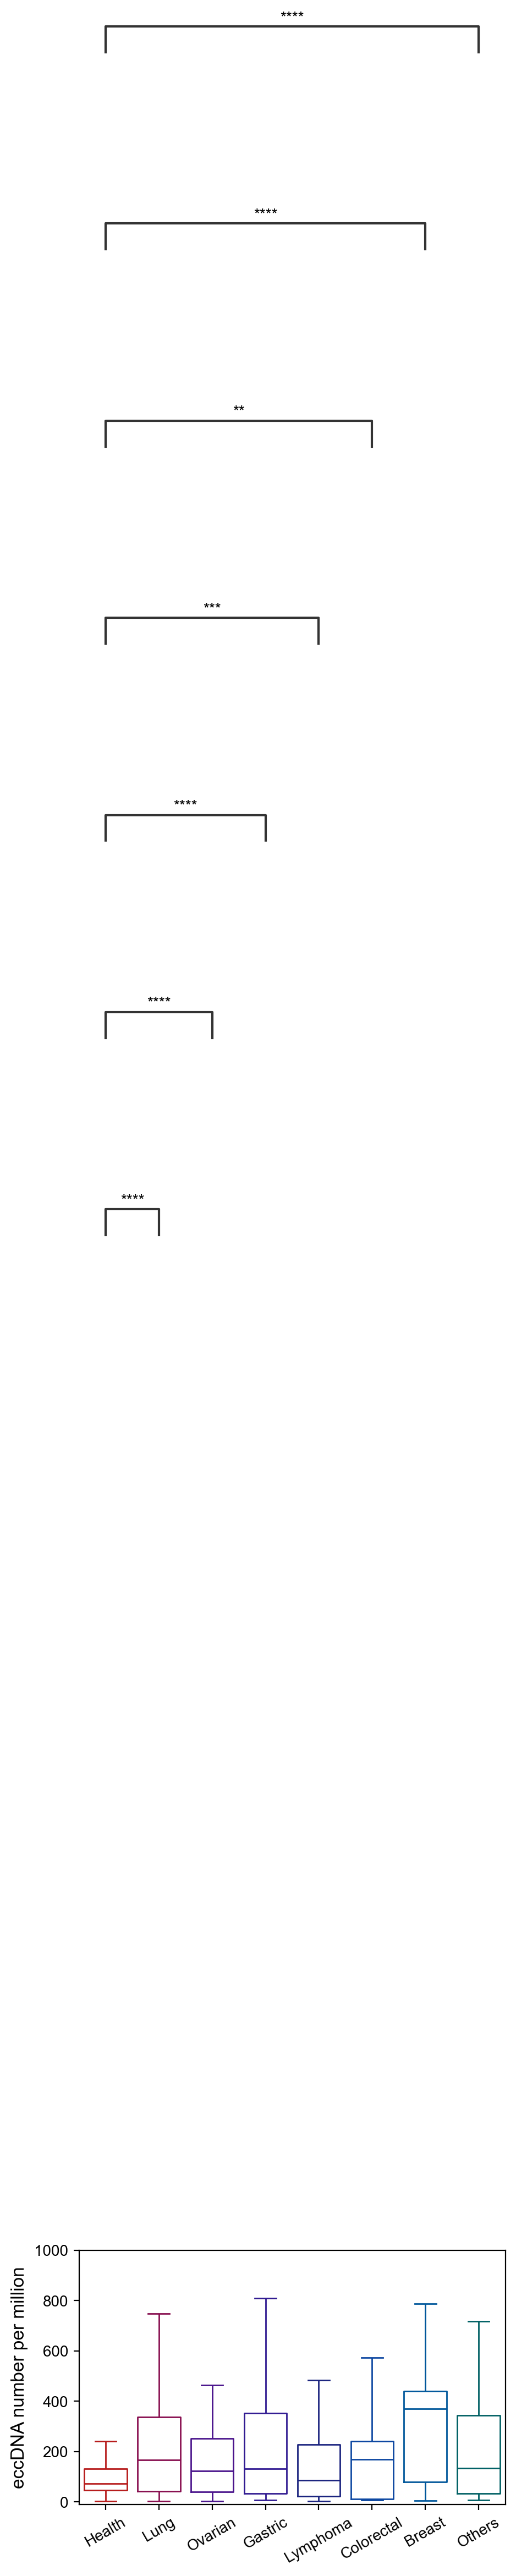

In [22]:
### 创建画布和坐标轴,不叠加散点图
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

### 绘制箱线图
sns.boxplot(
    data=eccDNA_count_df,
    x='ctype', y='epm', fill=False,
    #fill=False, color='k', 
    ax=ax,
    fliersize=0, saturation=1, linewidth=1,
    palette=['#b71c1c', '#880e4f', '#4a148c', '#311b92', '#1a237e', '#0d47a1', '#01579b', '#006064'],
    #meanline=True, showmeans=True, 
    meanprops={'c': 'k', 'lw': 1},
    #boxprops={'facecolor': 'none', 'edgecolor': 'k'}
)

### 叠加散点图
#sns.stripplot(data=filtered_eccDNA_count_df, x='ctype', y='epm', ax=ax, marker='o', color='k', size=4, alpha=0.8,
              #palette=['#661212', '#4c092f', '#260c4c', '#160f4c', '#0d133f', '#07234c', '#012e4c', '#003333'])

###添加统计显著性
box_pairs = [
    ("Health", "Lung"),
    ("Health", "Ovarian"),
    ("Health", "Gastric"),
    ("Health", "Lymphoma"),
    ("Health", "Colorectal"),
    ("Health", "Breast"),
    ("Health", "Others"),
]

# 添加显著性标记
annot = Annotator(ax, box_pairs, data=eccDNA_count_df, x="ctype", y="epm")
annot.configure(test='t-test_ind', text_format='star', loc='outside')
annot.apply_and_annotate()

# 设置标签
plt.xlabel("")
plt.ylabel("eccDNA number per million", fontsize=12)
plt.ylim(-10,1000)

# 旋转 x 轴标签以提高可读性
plt.xticks(rotation=30)
#fig.savefig('/home/luosongwen/scantecc/2025_03_10_Figure_result/candidate_figure/Figure1b_boxplot_without_fill.pdf', bbox_inches='tight')
plt.show()

/tmp/ipykernel_28422/2170988817.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Health vs. Lung: t-test independent samples, P_val:7.433e-09 t=-5.899e+00
Health vs. Ovarian: t-test independent samples, P_val:1.060e-06 t=-4.981e+00
Health vs. Gastric: t-test independent samples, P_val:7.764e-10 t=-6.367e+00
Health vs. Lymphoma: t-test independent samples, P_val:1.874e-04 t=-3.786e+00
Health vs. Colorectal: t-test independent samples, P_val:1.340e-03 t=-3.243e+00
Health vs. Breast: t-test independent samples, P_val:1.161e-09 t=-6.328e+00
Health vs. Others: t-test independent samples, P_val:5.341e-08 t=-5.595e+00


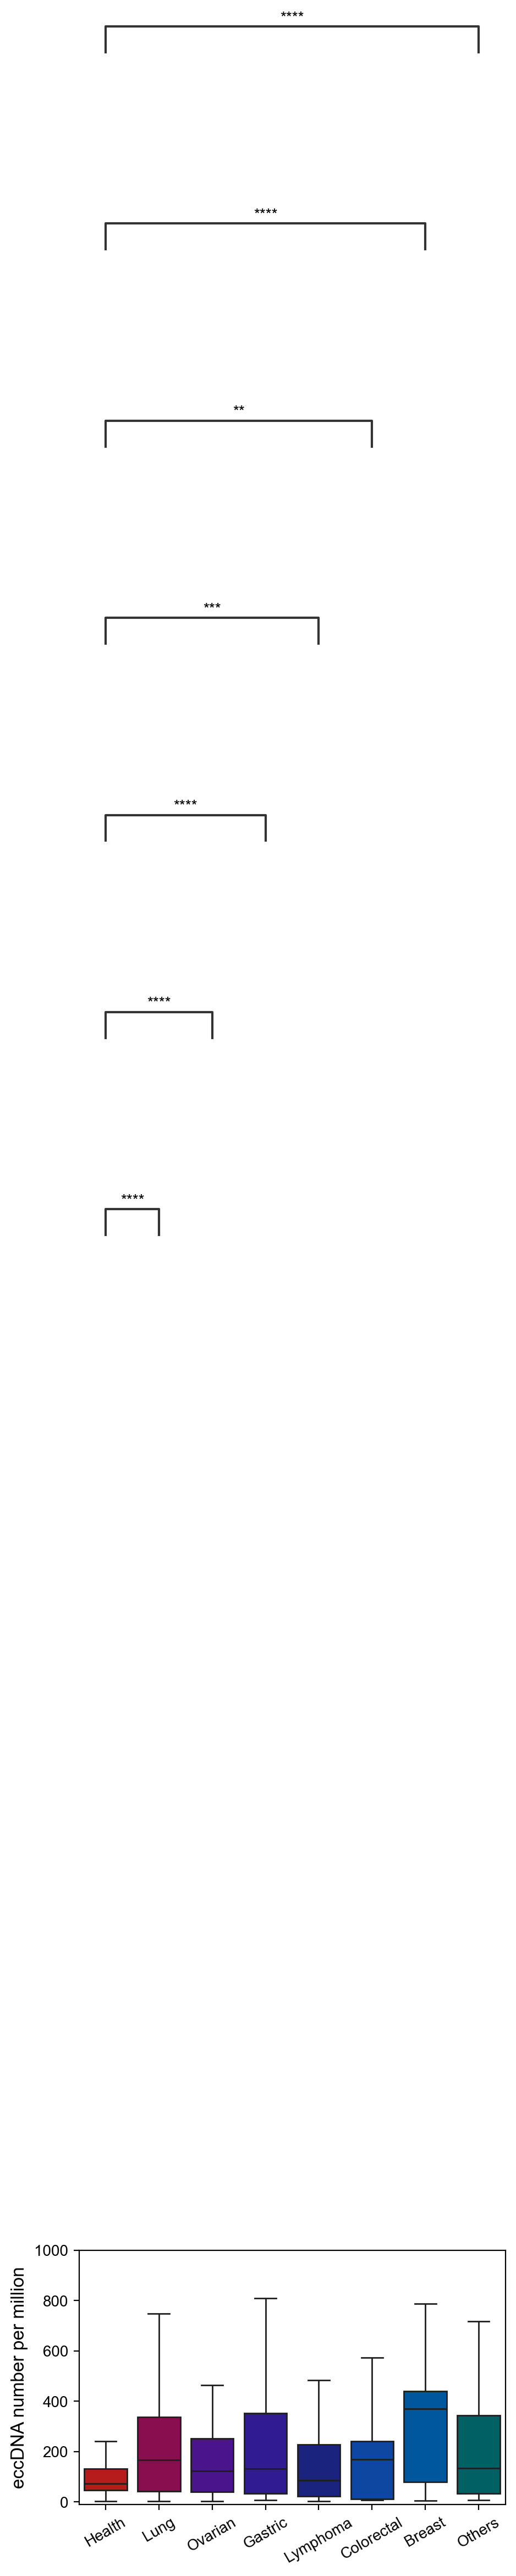

In [25]:
### 创建画布和坐标轴,不叠加散点图
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

### 绘制箱线图
sns.boxplot(
    data=eccDNA_count_df,
    x='ctype', y='epm', fill=True,
    #fill=False, color='k', 
    ax=ax,
    fliersize=0, saturation=1, linewidth=1,
    palette=['#b71c1c', '#880e4f', '#4a148c', '#311b92', '#1a237e', '#0d47a1', '#01579b', '#006064'],
    #meanline=True, showmeans=True, 
    meanprops={'c': 'k', 'lw': 1},
    #boxprops={'facecolor': 'none', 'edgecolor': 'k'}
)

### 叠加散点图
#sns.stripplot(data=filtered_eccDNA_count_df, x='ctype', y='epm', ax=ax, marker='o', color='k', size=4, alpha=0.8,
              #palette=['#661212', '#4c092f', '#260c4c', '#160f4c', '#0d133f', '#07234c', '#012e4c', '#003333'])

###添加统计显著性
box_pairs = [
    ("Health", "Lung"),
    ("Health", "Ovarian"),
    ("Health", "Gastric"),
    ("Health", "Lymphoma"),
    ("Health", "Colorectal"),
    ("Health", "Breast"),
    ("Health", "Others"),
]

# 添加显著性标记
annot = Annotator(ax, box_pairs, data=eccDNA_count_df, x="ctype", y="epm")
annot.configure(test='t-test_ind', text_format='star', loc='outside')
annot.apply_and_annotate()

# 设置标签
plt.xlabel("")
plt.ylabel("eccDNA number per million", fontsize=12)
plt.ylim(-10,1000)
# 旋转 x 轴标签以提高可读性
plt.xticks(rotation=30)
#fig.savefig('/home/luosongwen/scantecc/2025_03_10_Figure_result/candidate_figure/Figure1b_boxplot_with_fill.pdf', bbox_inches='tight')
plt.show()

In [15]:
eccDNA_count_df.to_csv("/home/luosongwen/scantecc/2025_03_10_Figure_result/Figure/Figure1B/Figure1B_eccDNA_count.csv", index=None, sep='\t')

### Figure 1D Normalized cell-free eccDNA counts detected in healthy individuals and cancer patients, stratified by 10-fold genomic length bins.

In [3]:
# 指定目录路径
directory = "/home/luosongwen/scantecc/2025_new_data/Scantecc_eccDNA_bed"

# 获取目录下所有bed文件路径
bed_files = glob(os.path.join(directory, "*.bed"))

# 创建一个空列表用于存储每个文件生成的DataFrame
dataframes = []

# 循环读取所有bed文件
for file in bed_files:
    # 提取文件名（不含路径和扩展名）
    file_id = os.path.splitext(os.path.basename(file))[0]
    
    # 读取bed文件为DataFrame并设置列名
    df = pd.read_csv(file, sep='\t', header=None, names=["chr", "start", "end", "ecc_id"], engine='python')
    
    # 添加'id'列作为文件名
    df['id'] = file_id
    df["length"] = df["end"]-df["start"]
    # 将DataFrame添加到列表中
    dataframes.append(df)

# 将所有DataFrame合并为一个总DataFrame
combined_df = pd.concat(dataframes, ignore_index=True)

In [4]:
### metadata文件读入与处理
metadata = pd.read_table("/home/luosongwen/scantecc/2025_new_data/meta_information.txt", index_col=0)
id2label = metadata['label'].to_dict()
ctype_mapping = {
    '正常对照': 'Healthy',
    '肺癌': 'Lung',
    '卵巢癌':'Ovarian',
    '胃癌':'Gastric',
    '淋巴瘤':'Lymphoma',
    '结直肠癌':'Colorectal',
    '乳腺癌': 'Breast',
    'other':'Others'
}
metadata['ctype'] = metadata['ctype'].replace(ctype_mapping)
# 删除所有以 'Unnamed:' 开头的列
metadata = metadata.loc[:, ~metadata.columns.str.startswith('Unnamed:')]

# 修改列名
metadata = metadata.rename(columns={
    "病理分期": "Pathological_Stage",
    "简化分期": "Simplified_Stage",
    "Gender(女=1_x000D_\n男=2)": "Gender"
})

# 替换 Gender 列中的值
metadata["Gender"] = metadata["Gender"].replace({"1": "female", "2": "male"})
metadata["id"] = metadata.index

In [5]:
combined_df = combined_df.merge(metadata[['id', 'label', 'ctype']], on='id', how='left')

In [6]:
## drop chrM 去除线粒体上的cell-free eccDNA
combined_df.drop(combined_df.loc[combined_df['chr']=='chrM'].index, inplace = True)
combined_df.reset_index(inplace=True)
combined_df = combined_df[combined_df["length"] <= 10**6]
combined_df['label'] = combined_df['label'].replace({'Disease': 'Cancer', 'Normal': 'Health'})

In [7]:
###读入测序reads信息文件
reads_info = pd.read_csv("/home/luosongwen/scantecc/2025_new_data/reads_info.txt", sep='\t')
reads_info.rename(columns={"送测编号": "id"}, inplace=True)

In [8]:
# 定义 length 的区间和对应标签
bins = [1, 10, 100, 1000, 10000, 100000, 1000000]
labels = ['10^0-10^1', '10^1-10^2', '10^2-10^3', '10^3-10^4',
          '10^4-10^5', '10^5-10^6']

# 将 length 列分箱
combined_df['length_bin'] = pd.cut(combined_df['length'], bins=bins, labels=labels, right=False)

# 提取唯一样本信息（id、label、ctype）
unique_samples = combined_df[['id', 'label', 'ctype']].drop_duplicates()

# 创建所有样本与长度区间的笛卡尔积 (确保每个样本有所有区间)
all_combinations = pd.DataFrame(
    list(itertools.product(unique_samples['id'], labels)),
    columns=['id', 'length_bin']
)

# 合并以获取对应的 label 和 ctype 信息
all_combinations = all_combinations.merge(unique_samples, on='id', how='left')

# 统计 combined_df 中每个样本在每个长度区间的行数
length_counts = (
    combined_df.groupby(['id', 'length_bin'])
    .size()
    .reset_index(name='eccDNA_count')
)

# 将统计结果合并到所有组合中，未出现的长度区间填充为0
result_df = all_combinations.merge(length_counts, on=['id', 'length_bin'], how='left').fillna({'eccDNA_count': 0})

# 确保 eccDNA_count 为整数类型
result_df['eccDNA_count'] = result_df['eccDNA_count'].astype(int)

In [9]:
result_df = result_df.merge(reads_info[['id', 'MappedReads']], on='id', how='left')
result_df["epm"] = result_df["eccDNA_count"] / result_df["MappedReads"] * pow(10, 6)
#result_df['log_epm'] = result_df['epm'].map(lambda x:np.log2(x))
#result_df = result_df[~result_df["length_bin"].isin(["10^6-10^7", "10^7-10^8"])]
result_df = result_df[~result_df["length_bin"].isin(["10^0-10^1", "10^1-10^2"])]

In [10]:
result_df

,id,length_bin,label,ctype,eccDNA_count,MappedReads,epm
2,SE-187,10^2-10^3,Health,Healthy,2807,51657002.0,54.339197
3,SE-187,10^3-10^4,Health,Healthy,29,51657002.0,0.561395
4,SE-187,10^4-10^5,Health,Healthy,0,51657002.0,0.000000
5,SE-187,10^5-10^6,Health,Healthy,2,51657002.0,0.038717
8,SE-164,10^2-10^3,Health,Healthy,5837,57734964.0,101.099916
...,...,...,...,...,...,...,...
3905,HG632,10^5-10^6,Cancer,Ovarian,11,78625797.0,0.139903
3908,HG197,10^2-10^3,Cancer,Lung,6617,118191351.0,55.985484
3909,HG197,10^3-10^4,Cancer,Lung,41,118191351.0,0.346895
3910,HG197,10^4-10^5,Cancer,Lung,0,118191351.0,0.000000


In [13]:
result_df[result_df["id"] == "HG202"]

,id,length_bin,label,ctype,eccDNA_count,MappedReads,epm
662,HG202,10^2-10^3,Cancer,Lung,4661,27729413.0,168.088665
663,HG202,10^3-10^4,Cancer,Lung,12,27729413.0,0.432753
664,HG202,10^4-10^5,Cancer,Lung,0,27729413.0,0.000000
665,HG202,10^5-10^6,Cancer,Lung,11,27729413.0,0.396691


In [11]:
result_df["length_bin"].value_counts()

length_bin
10^2-10^3    652
10^3-10^4    652
10^4-10^5    652
10^5-10^6    652
Name: count, dtype: int64

/tmp/ipykernel_28422/3736200587.py:6: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.barplot(x='length_bin', y='epm', hue='label', data=result_df, ax=ax21, palette=palette_group,
/tmp/ipykernel_28422/3736200587.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax21.set_xticklabels(ax21.get_xticklabels(), rotation=30)
/home/luosongwen/miniconda3/envs/SPACEL/lib/python3.8/site-packages/statannotations/_Plotter.py:287: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  bbox = self.ax.transData.inverted().transform(
/home/luosongwen/miniconda3/envs/SPACEL/lib/python3.8/site-packages/statannotations/_Plotter.py:311: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  value_pos = data_to_ax.t

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

10^3-10^4_Health vs. 10^3-10^4_Cancer: t-test independent samples, P_val:5.646e-02 t=-1.911e+00
10^2-10^3_Health vs. 10^2-10^3_Cancer: t-test independent samples, P_val:8.737e-10 t=-6.223e+00
10^4-10^5_Health vs. 10^4-10^5_Cancer: t-test independent samples, P_val:5.512e-21 t=-9.731e+00
10^5-10^6_Health vs. 10^5-10^6_Cancer: t-test independent samples, P_val:4.444e-12 t=-7.055e+00


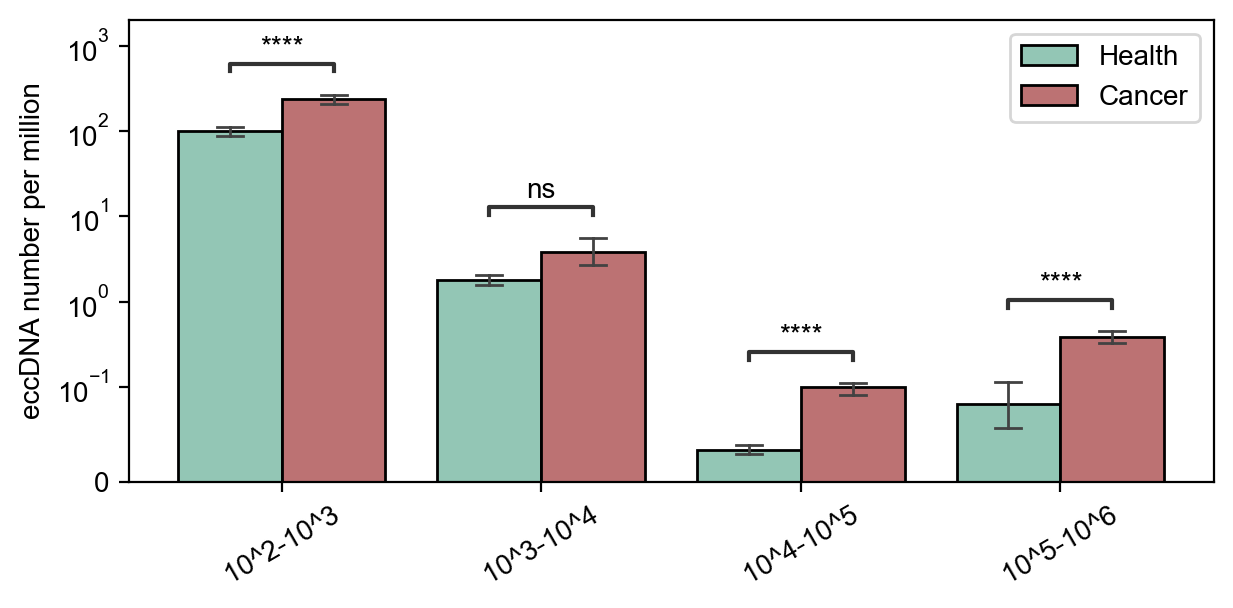

In [46]:
palette_group = {'Health': "#8ACEB8", 'Cancer': "#C86667"}

plt.figure(figsize=(7,3))
ax21 = plt.subplot(111)
# ax21 = brokenaxes(ylims=((0,.2),(4,14)))
sns.barplot(x='length_bin', y='epm', hue='label', data=result_df, ax=ax21, palette=palette_group, 
            errwidth=1, capsize=.2, hue_order=['Health','Cancer'], edgecolor="black", linewidth=1)
_ = ax21.set_yscale('symlog', linthresh=0.1)
#_ = ax21.set_ylim(0,500)
ax21.set_xlabel('')
ax21.set_ylabel('eccDNA number per million')

# 设置x轴标签旋转
ax21.set_xticklabels(ax21.get_xticklabels(), rotation=30)

pairs=[
    (("10^2-10^3", "Health"), ("10^2-10^3", "Cancer")),
    (("10^3-10^4", "Health"), ("10^3-10^4", "Cancer")),
    (("10^4-10^5", "Health"), ("10^4-10^5", "Cancer")),
    (("10^5-10^6", "Health"), ("10^5-10^6", "Cancer")),
    ]

x = "length_bin"
y = "epm"
hue = "label"
hue_order = ["Health","Cancer"]
annotator = Annotator(ax21, pairs, data=result_df, x=x, y=y, hue=hue, hue_order=hue_order)
annotator.configure(test='t-test_ind', text_format='star', verbose=2)
annotator.apply_and_annotate()
plt.legend(loc='best')
#plt.savefig("/home/luosongwen/scantecc/2025_03_10_Figure_result/Figure/Figure1C/refined_Figure1C_length_distribution.pdf", bbox_inches='tight')
plt.show()

/tmp/ipykernel_62851/2173258347.py:6: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.barplot(x='length_bin', y='epm', hue='label', data=result_df, ax=ax21, palette=palette_group,
/tmp/ipykernel_62851/2173258347.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax21.set_xticklabels(ax21.get_xticklabels(), rotation=30)
/home/luosongwen/miniconda3/envs/SPACEL/lib/python3.8/site-packages/statannotations/_Plotter.py:287: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  bbox = self.ax.transData.inverted().transform(
/home/luosongwen/miniconda3/envs/SPACEL/lib/python3.8/site-packages/statannotations/_Plotter.py:311: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  value_pos = data_to_ax.t

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

10^3-10^4_Health vs. 10^3-10^4_Cancer: t-test independent samples, P_val:5.646e-02 t=-1.911e+00
10^2-10^3_Health vs. 10^2-10^3_Cancer: t-test independent samples, P_val:8.737e-10 t=-6.223e+00
10^4-10^5_Health vs. 10^4-10^5_Cancer: t-test independent samples, P_val:5.512e-21 t=-9.731e+00
10^5-10^6_Health vs. 10^5-10^6_Cancer: t-test independent samples, P_val:4.444e-12 t=-7.055e+00


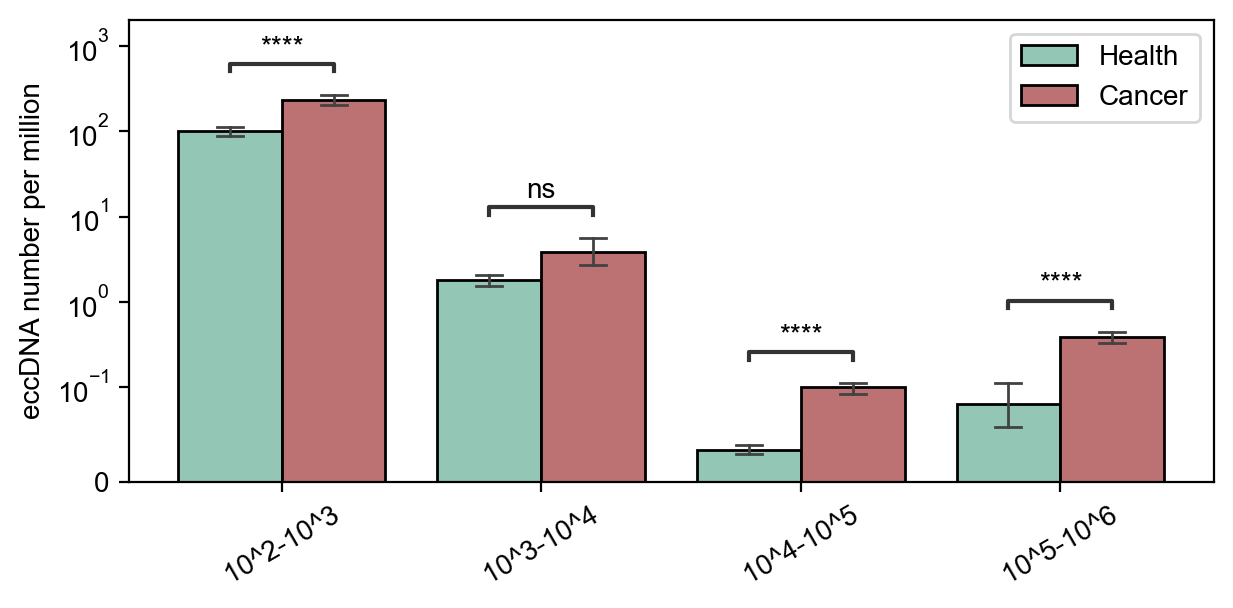

In [14]:
palette_group = {'Health': "#8ACEB8", 'Cancer': "#C86667"}

plt.figure(figsize=(7,3))
ax21 = plt.subplot(111)
# ax21 = brokenaxes(ylims=((0,.2),(4,14)))
sns.barplot(x='length_bin', y='epm', hue='label', data=result_df, ax=ax21, palette=palette_group, 
            errwidth=1, capsize=.2, hue_order=['Health','Cancer'], edgecolor="black", linewidth=1)
_ = ax21.set_yscale('symlog', linthresh=0.1)
#_ = ax21.set_ylim(0,500)
ax21.set_xlabel('')
ax21.set_ylabel('eccDNA number per million')

# 设置x轴标签旋转
ax21.set_xticklabels(ax21.get_xticklabels(), rotation=30)

pairs=[
    (("10^2-10^3", "Health"), ("10^2-10^3", "Cancer")),
    (("10^3-10^4", "Health"), ("10^3-10^4", "Cancer")),
    (("10^4-10^5", "Health"), ("10^4-10^5", "Cancer")),
    (("10^5-10^6", "Health"), ("10^5-10^6", "Cancer")),
    ]

x = "length_bin"
y = "epm"
hue = "label"
hue_order = ["Health","Cancer"]
annotator = Annotator(ax21, pairs, data=result_df, x=x, y=y, hue=hue, hue_order=hue_order)
annotator.configure(test='t-test_ind', text_format='star', verbose=2)
annotator.apply_and_annotate()
plt.legend(loc='best')
plt.savefig("/home/luosongwen/scantecc/2025_03_10_Figure_result/candidate_figure/refined_Figure1d_length_distribution.pdf", bbox_inches='tight')
plt.show()

In [47]:
for idx in result_df['length_bin'].unique():
    tmp_df = result_df[result_df['length_bin']==idx]
    print(idx)
    print(ranksums(tmp_df[tmp_df['label']=='Health']['epm'], 
                   tmp_df[tmp_df['label']=='Cancer']['epm'])[1])

10^2-10^3
1.1689397514009702e-06
10^3-10^4
0.13177028870013066
10^4-10^5
1.843286343652769e-25
10^5-10^6
4.2045737317060066e-23


In [48]:
### 根据epm均值 计算Fold Change
vs_ls = []
for idx in result_df['length_bin'].unique():
#     print(idx)
    tmp_df = result_df[result_df['length_bin']==idx]
    vs = (tmp_df[tmp_df['label']=='Cancer']['epm'].mean()+1e-5) / (tmp_df[tmp_df['label']=='Health']['epm'].mean()+1e-5)
#     vs_ls.append(np.log2(vs))
    vs_ls.append(vs)

In [49]:
vs_ls

[2.3695184610586497, 2.1402678342355284, 2.998550424471067, 4.708336553824963]

In [50]:
color_df = pd.DataFrame({'ratio':vs_ls}, index=result_df['length_bin'].unique()).sort_values('ratio')
color_df['c'] = list(sns.color_palette('Blues',4).as_hex())
color_df = color_df.loc[result_df['length_bin'].unique()]

(0.0, 5.0)

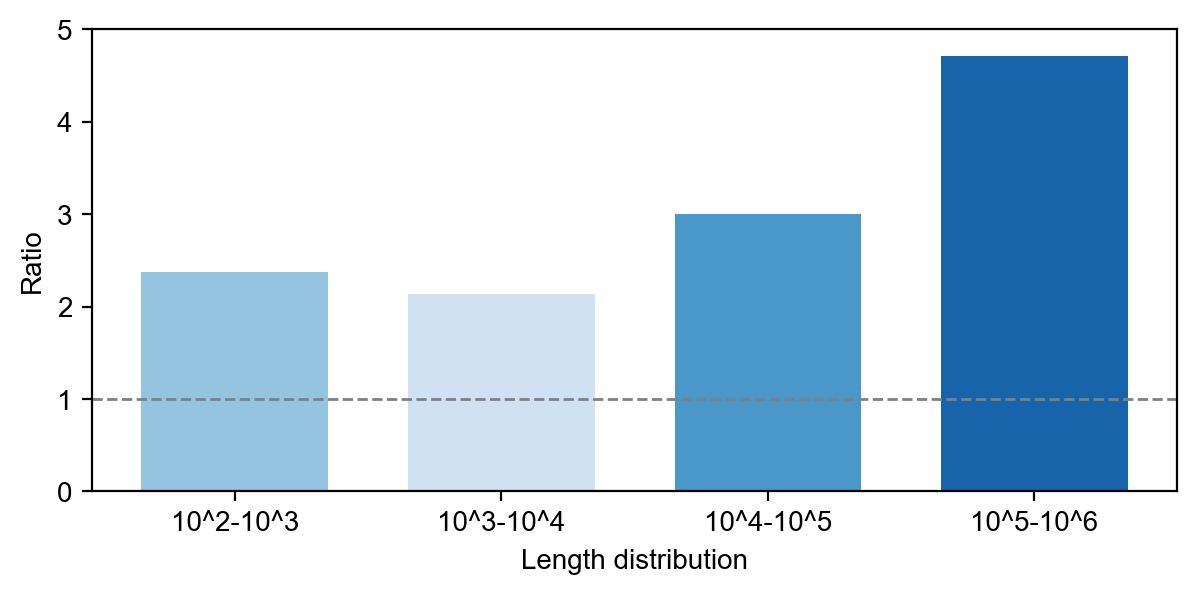

In [51]:
plt.figure(figsize=(7,3))
ax21 = plt.subplot(111)
ax21.bar(result_df['length_bin'].unique(), color_df['ratio'], color=color_df['c'], width=.7)
ax21.set_xlabel('Length distribution')
ax21.set_ylabel('Ratio')
ax21.axhline(y=1, color='gray', linestyle='--', linewidth=1.0)
ax21.set_ylim(0,5)
#plt.savefig("/home/luosongwen/scantecc/2025_03_10_Figure_result/Figure/Figure1C/refined_Figure1C_length_distribution_fold_change.pdf", bbox_inches='tight')